# Импортируем фреймы

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
print(tf.__version__)



2.9.2


## Загружаем и анализируем данные

In [3]:

df = pd.read_csv('/content/drive/MyDrive/df/ebw_data.csv')


In [4]:
df

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48
...,...,...,...,...,...,...
67,44,146,9.0,60,1.20,1.72
68,45,146,9.0,60,1.36,1.76
69,45,146,9.0,60,1.28,1.76
70,45,146,9.0,60,1.28,1.76


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


In [6]:
df.describe()

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


In [7]:
df.nunique()
df.duplicated().sum()
df.isna()
df.isna().sum()


IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

Данные достаточно чистые.

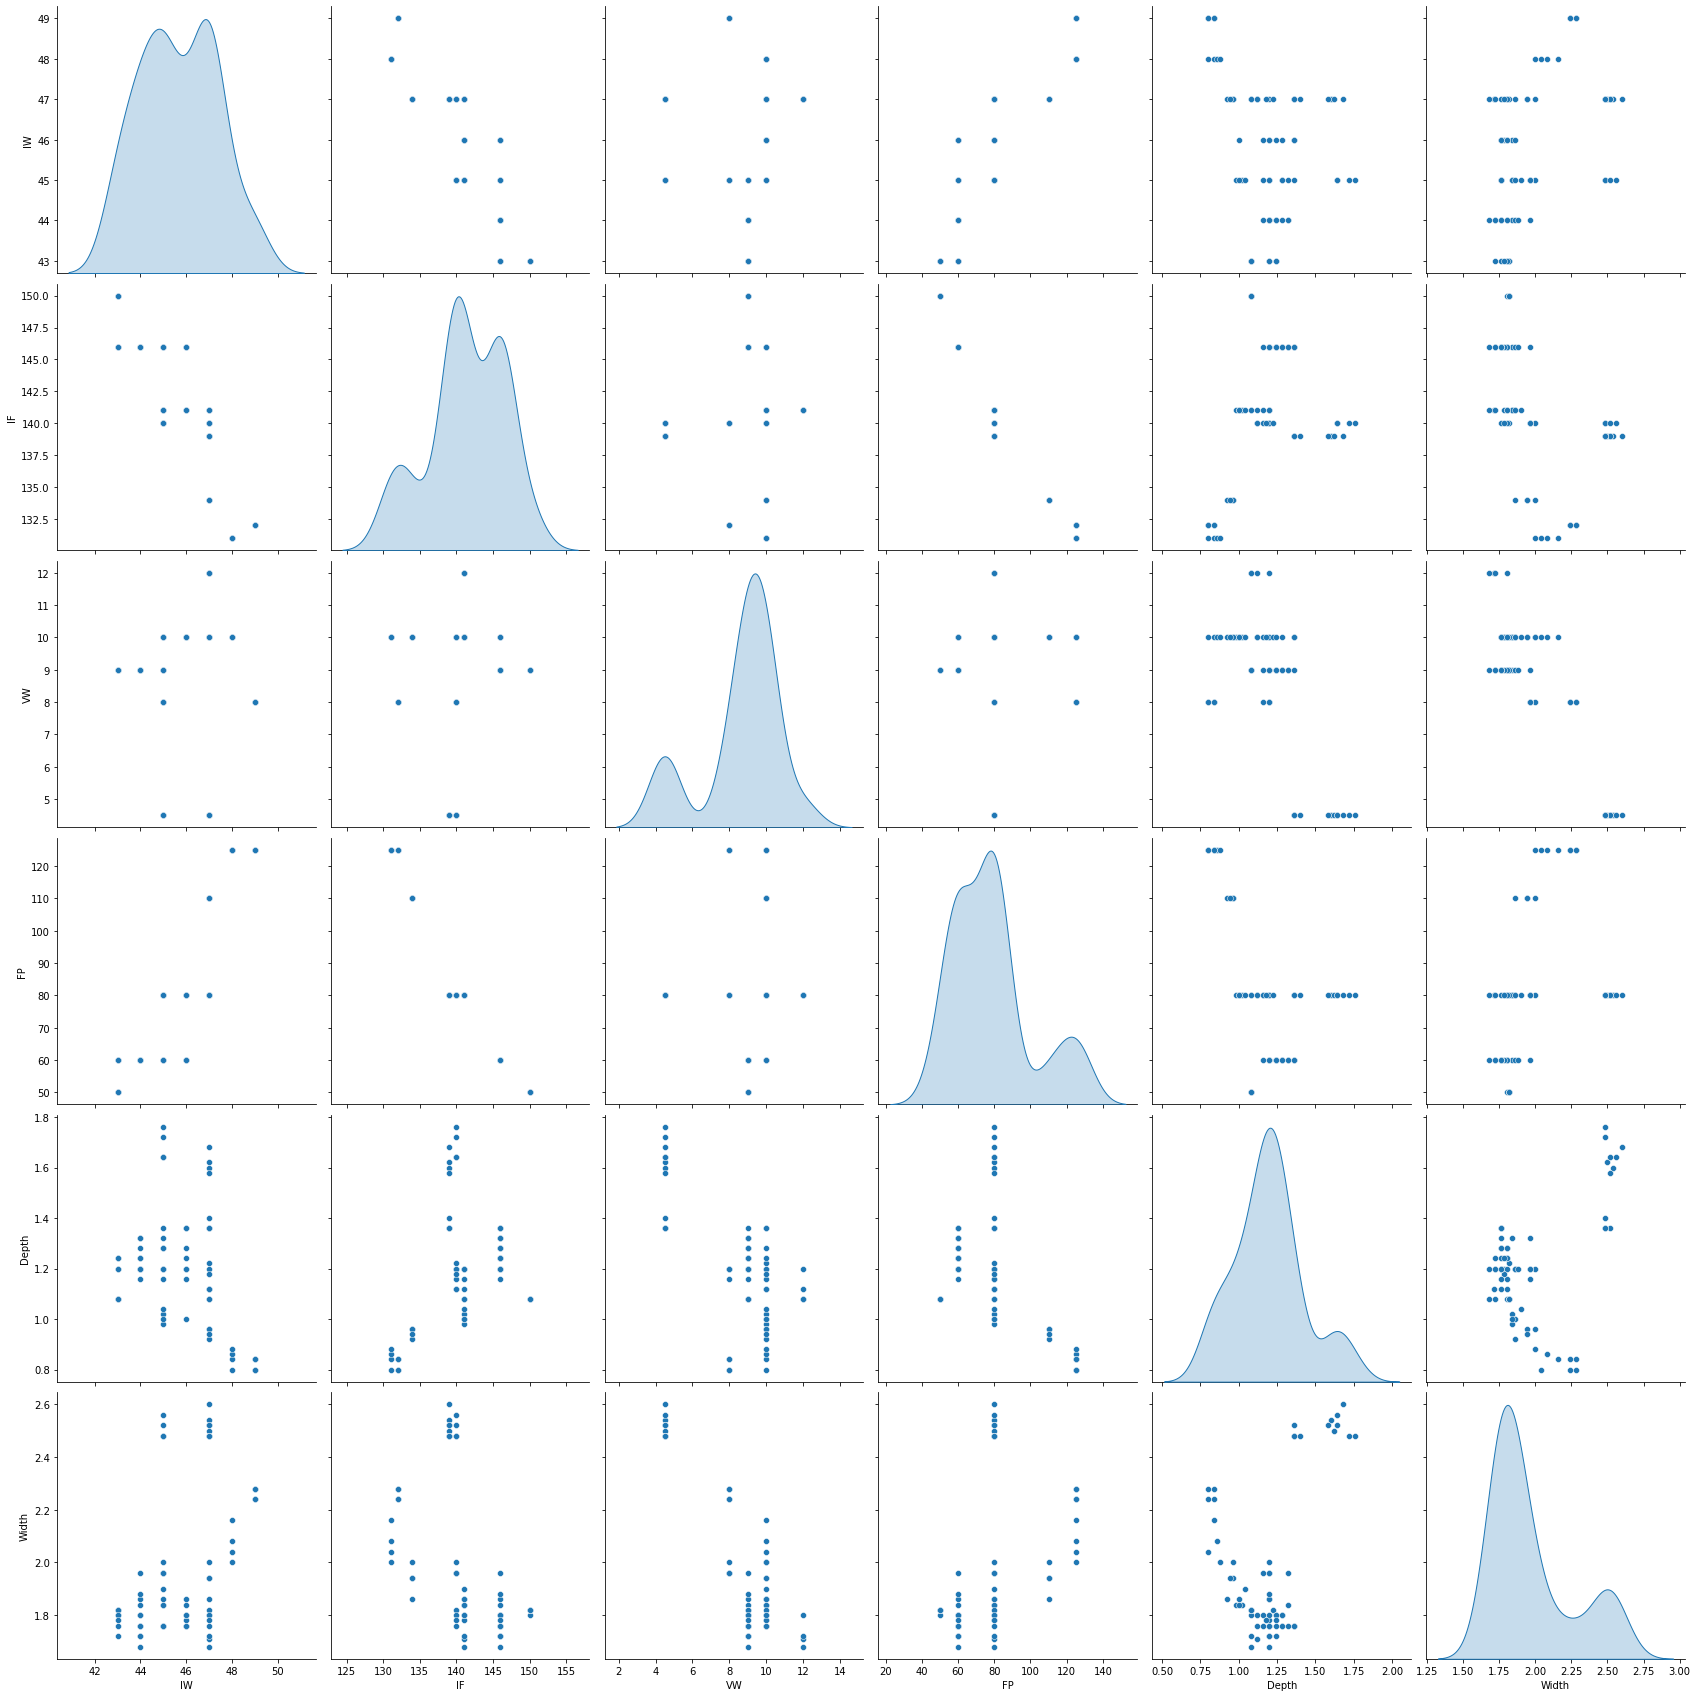

In [8]:
sns.pairplot(df, height=4, diag_kind='kde');

Данных слишком мало, явная зависимость видна между шириной и глубиной шва, что логично ведь шов имеет форму конуса. Посмотрим на корреляции:

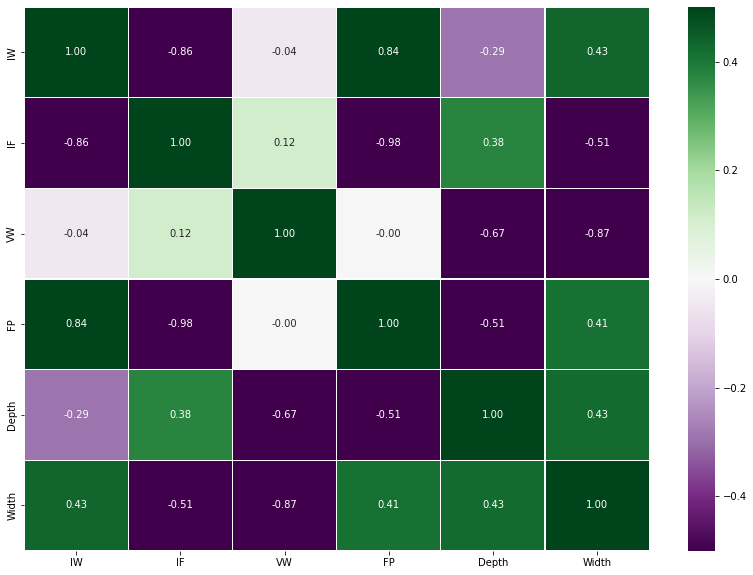

In [9]:
cor_map = df.corr()
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(cor_map, vmin=-0.5, vmax=0.5, annot=True,
fmt='.2f',cmap='PRGn', ax=ax, linewidths = 0.1)
plt.show()


Посмотрим нужна ли нормализация:

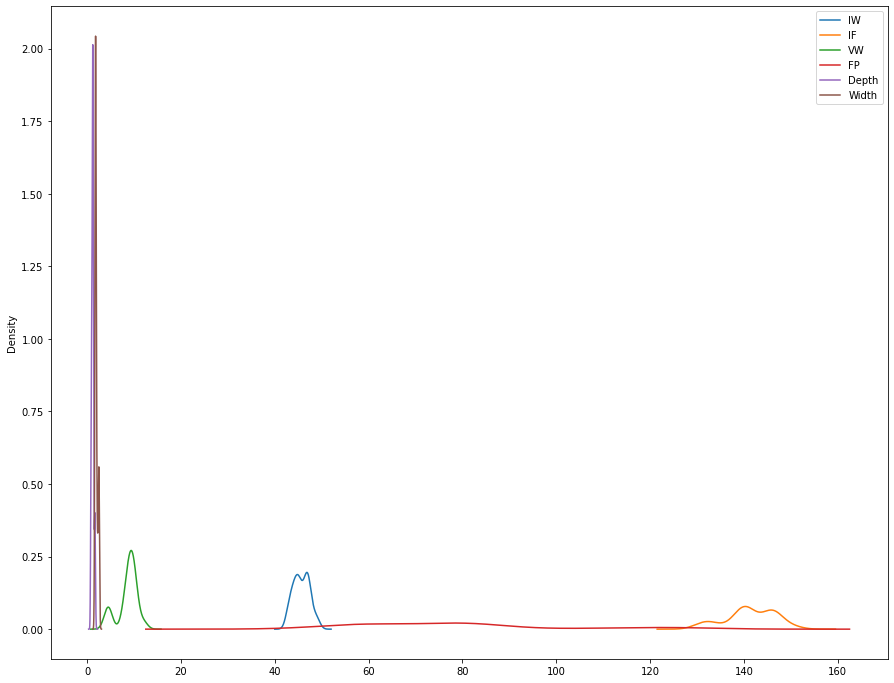

In [10]:
fig, ax = plt.subplots(figsize=(15, 12))
df.plot(kind='kde', ax=ax)

Нормализуем данные

In [11]:
scaler = preprocessing.MinMaxScaler()
names = df.columns
d = scaler.fit_transform(df)
df_norm = pd.DataFrame(d, columns=names).round(2)
df_norm.head()


,IW,IF,VW,FP,Depth,Width
0,0.67,0.42,0.0,0.4,0.83,0.93
1,0.67,0.42,0.0,0.4,0.85,0.89
2,0.67,0.42,0.0,0.4,0.92,1.00
3,0.67,0.42,0.0,0.4,0.81,0.91
4,0.33,0.47,0.0,0.4,1.00,0.87


Создадим тренеровочные выборки.

In [12]:
y_traindr = df_norm.pop('Width').values
y_traind = df_norm.pop('Depth').values
y_train1 = df.pop('Width').values
y_train2 = df.pop('Depth').values
x_train = df_norm.values


In [ ]:
x_train.shape

(72, 4)

## Обучим модель последовательной нейросети

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Было опробовано несколько вариантов с различными функциями активации и количеством нейронов в слое. Остановимся на этом. Создаем модель для предсказания первого параметра:

In [14]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))

In [24]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                320       
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
model.compile(optimizer='nadam', loss='mse', metrics=['mae'])

Изменение размера батче к положительному эффекту не привело, оставил по умолчанию 32.

In [16]:
history = model.fit(x_train, 
                    y_train1,
                    epochs=100, 
                    validation_split=0.1, 
                    verbose=2)

Epoch 1/100
2/2 - 4s - loss: 4.0757 - mae: 1.9992 - val_loss: 3.0284 - val_mae: 1.7400 - 4s/epoch - 2s/step
Epoch 2/100
2/2 - 0s - loss: 4.0757 - mae: 1.9992 - val_loss: 3.0284 - val_mae: 1.7400 - 45ms/epoch - 23ms/step
Epoch 3/100
2/2 - 0s - loss: 4.0757 - mae: 1.9992 - val_loss: 3.0284 - val_mae: 1.7400 - 69ms/epoch - 34ms/step
Epoch 4/100
2/2 - 0s - loss: 4.0757 - mae: 1.9992 - val_loss: 3.0284 - val_mae: 1.7400 - 54ms/epoch - 27ms/step
Epoch 5/100
2/2 - 0s - loss: 4.0757 - mae: 1.9992 - val_loss: 3.0284 - val_mae: 1.7400 - 61ms/epoch - 30ms/step
Epoch 6/100
2/2 - 0s - loss: 4.0757 - mae: 1.9992 - val_loss: 3.0284 - val_mae: 1.7400 - 58ms/epoch - 29ms/step
Epoch 7/100
2/2 - 0s - loss: 4.0757 - mae: 1.9992 - val_loss: 3.0284 - val_mae: 1.7400 - 54ms/epoch - 27ms/step
Epoch 8/100
2/2 - 0s - loss: 4.0757 - mae: 1.9992 - val_loss: 3.0284 - val_mae: 1.7400 - 95ms/epoch - 47ms/step
Epoch 9/100
2/2 - 0s - loss: 4.0757 - mae: 1.9992 - val_loss: 3.0284 - val_mae: 1.7400 - 65ms/epoch - 32ms/s

Создаем модель для предсказания первого параметра:

In [17]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='relu'))

In [18]:
model2.compile(optimizer='nadam', loss='mse', metrics=['mae'])

In [ ]:
print(model2.summary())

In [19]:
history2 = model2.fit(x_train, 
                    y_train2,
                    epochs=100, 
                    validation_split=0.1, 
                    verbose=2)

Epoch 1/100
2/2 - 1s - loss: 1.4669 - mae: 1.1881 - val_loss: 1.5790 - val_mae: 1.2550 - 1s/epoch - 532ms/step
Epoch 2/100
2/2 - 0s - loss: 1.4669 - mae: 1.1881 - val_loss: 1.5790 - val_mae: 1.2550 - 31ms/epoch - 15ms/step
Epoch 3/100
2/2 - 0s - loss: 1.4669 - mae: 1.1881 - val_loss: 1.5790 - val_mae: 1.2550 - 31ms/epoch - 15ms/step
Epoch 4/100
2/2 - 0s - loss: 1.4669 - mae: 1.1881 - val_loss: 1.5790 - val_mae: 1.2550 - 31ms/epoch - 16ms/step
Epoch 5/100
2/2 - 0s - loss: 1.4669 - mae: 1.1881 - val_loss: 1.5790 - val_mae: 1.2550 - 31ms/epoch - 15ms/step
Epoch 6/100
2/2 - 0s - loss: 1.4669 - mae: 1.1881 - val_loss: 1.5790 - val_mae: 1.2550 - 30ms/epoch - 15ms/step
Epoch 7/100
2/2 - 0s - loss: 1.4669 - mae: 1.1881 - val_loss: 1.5790 - val_mae: 1.2550 - 33ms/epoch - 16ms/step
Epoch 8/100
2/2 - 0s - loss: 1.4669 - mae: 1.1881 - val_loss: 1.5790 - val_mae: 1.2550 - 36ms/epoch - 18ms/step
Epoch 9/100
2/2 - 0s - loss: 1.4669 - mae: 1.1881 - val_loss: 1.5790 - val_mae: 1.2550 - 31ms/epoch - 16m

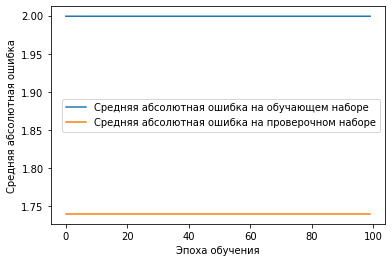

In [20]:
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

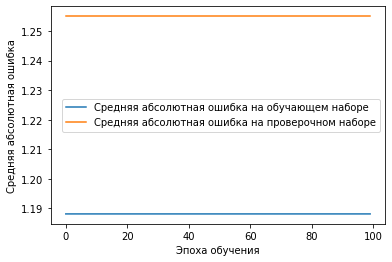

In [21]:
plt.plot(history2.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history2.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

Создадим функцию для сравнения моделей.

In [22]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [23]:
predictions = model.predict(x_train)
predictions2 = model2.predict(x_train)

3/3 [==============================] - 0s 5ms/step


In [25]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_train1, predictions)

Test set evaluation:
_____________________________________
MAE: 1.9704166666666667
MSE: 3.9593236111111114
RMSE: 1.9898049178527808
R2 Square -50.5659324881349
__________________________________


In [26]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_train2, predictions2)

Test set evaluation:
_____________________________________
MAE: 1.1955555555555555
MSE: 1.479311111111111
RMSE: 1.2162693415157315
R2 Square -28.611080907428452
__________________________________


In [27]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(x_train, y_train1)

test_pred = rf_reg.predict(x_train)
train_pred = rf_reg.predict(x_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_train1, test_pred)





Test set evaluation:
_____________________________________
MAE: 0.031037737557195536
MSE: 0.0018574366412777705
RMSE: 0.04309798883100893
R2 Square 0.9758088850892795
__________________________________


In [28]:
rf_reg1 = RandomForestRegressor(n_estimators=1000)
rf_reg1.fit(x_train, y_train2)
test_pred1 = rf_reg1.predict(x_train)
train_pred1 = rf_reg1.predict(x_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_train2, test_pred1)


Test set evaluation:
_____________________________________
MAE: 0.04302452911307789
MSE: 0.0033637508036478297
RMSE: 0.05799785171579918
R2 Square 0.9326684586824805
__________________________________


In [31]:
from sklearn.linear_model import Ridge

model3 = Ridge(alpha=100, solver='cholesky', tol=0.001, random_state=10)
model3.fit(x_train, y_train1)
pred1 = model3.predict(x_train)

test_pred2 = model3.predict(x_train)


print('Test set evaluation:\n_____________________________________')
print_evaluate(y_train1, test_pred2)

Test set evaluation:
_____________________________________
MAE: 0.2083259515091886
MSE: 0.06678981101373833
RMSE: 0.2584372477289958
R2 Square 0.13013453207902792
__________________________________


In [32]:
from sklearn.linear_model import Ridge

model4 = Ridge(alpha=100, solver='cholesky', tol=0.001, random_state=10)
model4.fit(x_train, y_train2)
pred1 = model4.predict(x_train)

test_pred3 = model4.predict(x_train)


print('Test set evaluation:\n_____________________________________')
print_evaluate(y_train2, test_pred3)

Test set evaluation:
_____________________________________
MAE: 0.15595093321434972
MSE: 0.045488738894078784
RMSE: 0.21328089200413333
R2 Square 0.08946081885524115
__________________________________


Ожидаемо случайный лес показал лучшие результаты.